In [5]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns


def generate_synthetic_data_from_mean_gini(target_mean, target_gini, size=100_000_000, seed=2_000):
    """
    Generate synthetic data from a lognormal distribution that approximates a given mean and Gini coefficient.

    Parameters:
        target_mean (float): Desired mean of the synthetic distribution.
        target_gini (float): Desired Gini coefficient of the distribution.
        size (int): Number of samples to generate (default: 100,000,000).
        seed (int or None): Random seed for reproducibility (default: None).

    Returns:
        np.ndarray: Synthetic data array.
    """

    # Set random seed if provided
    if seed is not None:
        np.random.seed(seed)

    # Gini of a lognormal: G = 2 * Φ(σ/√2) - 1
    def lognormal_gini(sigma: float) -> float:
        return 2 * norm.cdf(sigma / np.sqrt(2)) - 1

    # Objective function to minimize: match mean and Gini
    def objective(params: np.ndarray) -> float:
        mu, sigma = params
        mean = np.exp(mu + sigma**2 / 2)
        gini = lognormal_gini(sigma)
        # Weighted sum to prioritize Gini matching (since mean is easier to match)
        return 1 * (mean - target_mean) ** 2 + 100 * (gini - target_gini) ** 2

    def gini(array: np.ndarray) -> float:
        # Use the definition for population Gini
        array = np.sort(array)
        n = array.size
        index = np.arange(1, n + 1)
        return (2 * np.sum(index * array)) / (n * np.sum(array)) - (n + 1) / n

    # Initial guess
    initial_guess = [np.log(target_mean), 1.0]

    # Use a deterministic optimizer and tighter tolerance for reproducibility
    result = minimize(
        objective,
        initial_guess,
        bounds=[(None, None), (1e-6, None)],
        method="L-BFGS-B",
        options={"ftol": 1e-12, "gtol": 1e-8, "maxiter": 1e12}
    )
    mu_opt, sigma_opt = result.x

    # Use a fixed random seed for reproducibility
    rng = np.random.default_rng(seed)
    synthetic_data = rng.lognormal(mean=mu_opt, sigma=sigma_opt, size=size)

    # Calculate the mean and Gini of the generated data
    generated_mean = np.mean(synthetic_data)
    generated_gini = gini(synthetic_data)

    return synthetic_data, generated_mean, generated_gini, target_mean, target_gini

synthetic_data_uk_gapminder, generated_mean_uk_gapminder, generated_gini_uk_gapminder, target_mean_uk_gapminder, target_gini_uk_gapminder = generate_synthetic_data_from_mean_gini(target_mean=3784.226727, target_gini=0.5845)
synthetic_data_uk_moatsos, generated_mean_uk_moatsos, generated_gini_uk_moatsos, target_mean_uk_moatsos, target_gini_uk_moatsos = generate_synthetic_data_from_mean_gini(target_mean=1250.072, target_gini=0.5927)
synthetic_data_uk_mpd_gapminder, generated_mean_uk_mpd_gapminder, generated_gini_uk_mpd_gapminder, target_mean_uk_mpd_gapminder, target_gini_uk_mpd_gapminder = generate_synthetic_data_from_mean_gini(target_mean=3306, target_gini=0.5845)
synthetic_data_uk_mpd_moatsos, generated_mean_uk_mpd_moatsos, generated_gini_uk_mpd_moatsos, target_mean_uk_mpd_moatsos, target_gini_uk_mpd_moatsos = generate_synthetic_data_from_mean_gini(target_mean=3306, target_gini=0.5927)

synthetic_data_sweden_gapminder, generated_mean_sweden_gapminder, generated_gini_sweden_gapminder, target_mean_sweden_gapminder, target_gini_sweden_gapminder = generate_synthetic_data_from_mean_gini(target_mean=1619.685668, target_gini=0.4956)
synthetic_data_sweden_moatsos, generated_mean_sweden_moatsos, generated_gini_sweden_moatsos, target_mean_sweden_moatsos, target_gini_sweden_moatsos = generate_synthetic_data_from_mean_gini(target_mean=445.4332, target_gini=0.5544166)
synthetic_data_sweden_mpd_gapminder, generated_mean_sweden_mpd_gapminder, generated_gini_sweden_mpd_gapminder, target_mean_sweden_mpd_gapminder, target_gini_sweden_mpd_gapminder = generate_synthetic_data_from_mean_gini(target_mean=1415, target_gini=0.4956)
synthetic_data_sweden_mpd_moatsos, generated_mean_sweden_mpd_moatsos, generated_gini_sweden_mpd_moatsos, target_mean_sweden_mpd_moatsos, target_gini_sweden_mpd_moatsos = generate_synthetic_data_from_mean_gini(target_mean=1415, target_gini=0.5544166)

In [6]:
def plot_synthetic_data(data, mean, gini, original_mean, original_gini, country, source, ipl):

    kde_plot = sns.kdeplot(
                data=data,
                log_scale=True,
                fill=True,
            )

    # Customize x-axis ticks to show 1, 2, 5, 10, 20, 50, 100, etc.
    # kde_plot.set(xscale="log")
    kde_plot.set_xticks([
                100,
                200,
                500,
                1000,
                2000,
                5000,
                10000,
                20000,
                50000,
                100000,
                200000,
            ])
    kde_plot.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    # Make the plot wider
    fig = kde_plot.get_figure()
    fig.set_size_inches(10, 6)


    # Add a title mentioning mean, gini, country, and source
    kde_plot.set_title(
        f"Mean: {mean:.2f} (original {original_mean:.2f}), Gini: {gini:.2f} (original {original_gini:.2f}), Country: {country}, Source: {source}",
        fontsize=16,
    )

    # Plot dotted vertical line for ipl
    kde_plot.axvline(x=ipl*365, color='gray', linestyle='--', label=f'IPL: {ipl:.2f} a day')

    # Estimate the percentage below this line
    percentage_below_ipl = np.sum(data < ipl*365) / len(data) * 100

    kde_plot.text(
        ipl*365 * 0.90,
        kde_plot.get_ylim()[1] * 0.05,
        f"{percentage_below_ipl:.1f}% living below {ipl:.2f} a day",
        color='gray',
        fontsize=12,
        ha='center',
        rotation=90,
    )


    plt.show()

In [7]:
def plot_country_distributions(country="UK"):
    """
    Plot all synthetic distributions for a specific country in a single figure.

    Parameters:
        country (str): Either "UK" or "Sweden"
    """
    # Set up the figure
    plt.figure(figsize=(14, 8))

    # Define colors for each distribution
    colors = plt.cm.Set1(np.linspace(0, 1, 4))

    if country == "UK":
        # List of UK distributions with their metadata
        distributions = [
            (synthetic_data_uk_gapminder, "UK - Gapminder (2017 prices)", colors[0], 2.15),
            (synthetic_data_uk_moatsos, "UK - Moatsos (2011 prices)", colors[1], 1.90),
            (synthetic_data_uk_mpd_gapminder, "UK - MPD + Gini Gapminder (2011 prices)", colors[2], 1.90),
            (synthetic_data_uk_mpd_moatsos, "UK - MPD + Gini Moatsos (2011 prices)", colors[3], 1.90),
        ]
    elif country == "Sweden":
        # List of Sweden distributions with their metadata
        distributions = [
            (synthetic_data_sweden_gapminder, "Sweden - Gapminder (2017 prices)", colors[0], 2.15),
            (synthetic_data_sweden_moatsos, "Sweden - Moatsos (2011 prices)", colors[1], 1.90),
            (synthetic_data_sweden_mpd_gapminder, "Sweden - MPD + Gini Gapminder (2011 prices)", colors[2], 1.90),
            (synthetic_data_sweden_mpd_moatsos, "Sweden - MPD + Gini Moatsos (2011 prices)", colors[3], 1.90),
        ]
    else:
        raise ValueError("Country must be either 'UK' or 'Sweden'")

    # Plot each distribution
    for data, label, color, ipl in distributions:
        sns.kdeplot(
            data=data,
            log_scale=True,
            fill=False,
            alpha=0.8,
            linewidth=3,
            label=label,
            color=color
        )

    # Customize x-axis
    plt.xscale('log')
    plt.xticks([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000])
    plt.gca().get_xaxis().set_major_formatter(plt.ScalarFormatter())

    # Add vertical lines for IPL thresholds
    plt.axvline(x=2.15*365, color='red', linestyle='--', alpha=0.7, linewidth=2, label='IPL: $2.15/day (2017 prices)')
    plt.axvline(x=1.90*365, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='IPL: $1.90/day (2011 prices)')

    # Customize the plot
    plt.xlabel('Annual Income (log scale)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'{country} - Synthetic Income Distributions by Data Source', fontsize=16, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
    plt.grid(True, alpha=0.3)

    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    plt.show()


def plot_country_distributions_with_stats(country="UK"):
    """
    Plot all synthetic distributions for a specific country with detailed statistics.

    Parameters:
        country (str): Either "UK" or "Sweden"
    """
    # Set up the figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Define colors for each distribution
    colors = plt.cm.Set1(np.linspace(0, 1, 4))

    if country == "UK":
        # List of UK distributions with their metadata and statistics
        distributions_data = [
            (synthetic_data_uk_gapminder, generated_mean_uk_gapminder, generated_gini_uk_gapminder,
             target_mean_uk_gapminder, target_gini_uk_gapminder, "UK - Gapminder (2017 prices)", colors[0], 2.15),
            (synthetic_data_uk_moatsos, generated_mean_uk_moatsos, generated_gini_uk_moatsos,
             target_mean_uk_moatsos, target_gini_uk_moatsos, "UK - Moatsos (2011 prices)", colors[1], 1.90),
            (synthetic_data_uk_mpd_gapminder, generated_mean_uk_mpd_gapminder, generated_gini_uk_mpd_gapminder,
             target_mean_uk_mpd_gapminder, target_gini_uk_mpd_gapminder, "UK - MPD + Gini Gapminder (2011 prices)", colors[2], 1.90),
            (synthetic_data_uk_mpd_moatsos, generated_mean_uk_mpd_moatsos, generated_gini_uk_mpd_moatsos,
             target_mean_uk_mpd_moatsos, target_gini_uk_mpd_moatsos, "UK - MPD + Gini Moatsos (2011 prices)", colors[3], 1.90),
        ]
    elif country == "Sweden":
        # List of Sweden distributions with their metadata and statistics
        distributions_data = [
            (synthetic_data_sweden_gapminder, generated_mean_sweden_gapminder, generated_gini_sweden_gapminder,
             target_mean_sweden_gapminder, target_gini_sweden_gapminder, "Sweden - Gapminder (2017 prices)", colors[0], 2.15),
            (synthetic_data_sweden_moatsos, generated_mean_sweden_moatsos, generated_gini_sweden_moatsos,
             target_mean_sweden_moatsos, target_gini_sweden_moatsos, "Sweden - Moatsos (2011 prices)", colors[1], 1.90),
            (synthetic_data_sweden_mpd_gapminder, generated_mean_sweden_mpd_gapminder, generated_gini_sweden_mpd_gapminder,
             target_mean_sweden_mpd_gapminder, target_gini_sweden_mpd_gapminder, "Sweden - MPD + Gini Gapminder (2011 prices)", colors[2], 1.90),
            (synthetic_data_sweden_mpd_moatsos, generated_mean_sweden_mpd_moatsos, generated_gini_sweden_mpd_moatsos,
             target_mean_sweden_mpd_moatsos, target_gini_sweden_mpd_moatsos, "Sweden - MPD + Gini Moatsos (2011 prices)", colors[3], 1.90),
        ]
    else:
        raise ValueError("Country must be either 'UK' or 'Sweden'")

    # Plot distributions on the first subplot
    for data, gen_mean, gen_gini, orig_mean, orig_gini, label, color, ipl in distributions_data:
        # Extract short label without price year for legend
        short_label = label.split(' (')[0].split(' - ')[1]
        price_year = "2017" if "2017" in label else "2011"

        sns.kdeplot(
            data=data,
            log_scale=True,
            fill=False,
            alpha=0.8,
            linewidth=3,
            label=f"{short_label} ({price_year}) - μ={gen_mean:.0f}, G={gen_gini:.2f}",
            color=color,
            ax=ax1
        )

    # Customize first subplot
    ax1.set_xscale('log')
    ax1.set_xticks([100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000])
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())

    # Add vertical lines for IPL thresholds
    ax1.axvline(x=2.15*365, color='red', linestyle='--', alpha=0.7, linewidth=2, label='IPL: $2.15/day (2017)')
    ax1.axvline(x=1.90*365, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='IPL: $1.90/day (2011)')

    ax1.set_xlabel('Annual Income (log scale)', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.set_title(f'{country} - Synthetic Income Distributions', fontsize=14, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # Create statistics table for the second subplot
    stats_data = []
    for data, gen_mean, gen_gini, orig_mean, orig_gini, label, color, ipl in distributions_data:
        # Calculate poverty rate using the appropriate poverty line for each source
        if "Gapminder" in label and "2017" in label:
            # Gapminder uses 2017 prices, so use $2.15/day line
            poverty_rate = np.sum(data < 2.15*365) / len(data) * 100
            poverty_line = "$2.15/day (2017)"
            price_year = "2017"
        else:
            # Moatsos and MPD use 2011 prices, so use $1.90/day line
            poverty_rate = np.sum(data < 1.90*365) / len(data) * 100
            poverty_line = "$1.90/day (2011)"
            price_year = "2011"

        # Shorten label for table
        short_label = label.split(' (')[0].split(' - ')[1]

        stats_data.append([
            short_label,
            price_year,
            f"{orig_mean:.0f}",
            f"{gen_mean:.0f}",
            f"{orig_gini:.3f}",
            f"{gen_gini:.3f}",
            f"{poverty_rate:.1f}%"
        ])

    # Create table
    ax2.axis('tight')
    ax2.axis('off')

    headers = ['Source', 'Price\nYear', 'Target\nMean', 'Generated\nMean', 'Target\nGini', 'Generated\nGini',
               'Extreme\nPoverty Rate']

    table = ax2.table(cellText=stats_data, colLabels=headers, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.3, 2.2)

    # Color code the table rows to match the distributions
    for i, (_, _, _, _, _, _, color, _) in enumerate(distributions_data):
        for j in range(len(headers)):
            table[(i+1, j)].set_facecolor(color)
            table[(i+1, j)].set_alpha(0.3)

    ax2.set_title(f'{country} - Distribution Statistics\n(Gapminder: $2.15/day 2017, Others: $1.90/day 2011)',
                  fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

UK Distribution Analysis:


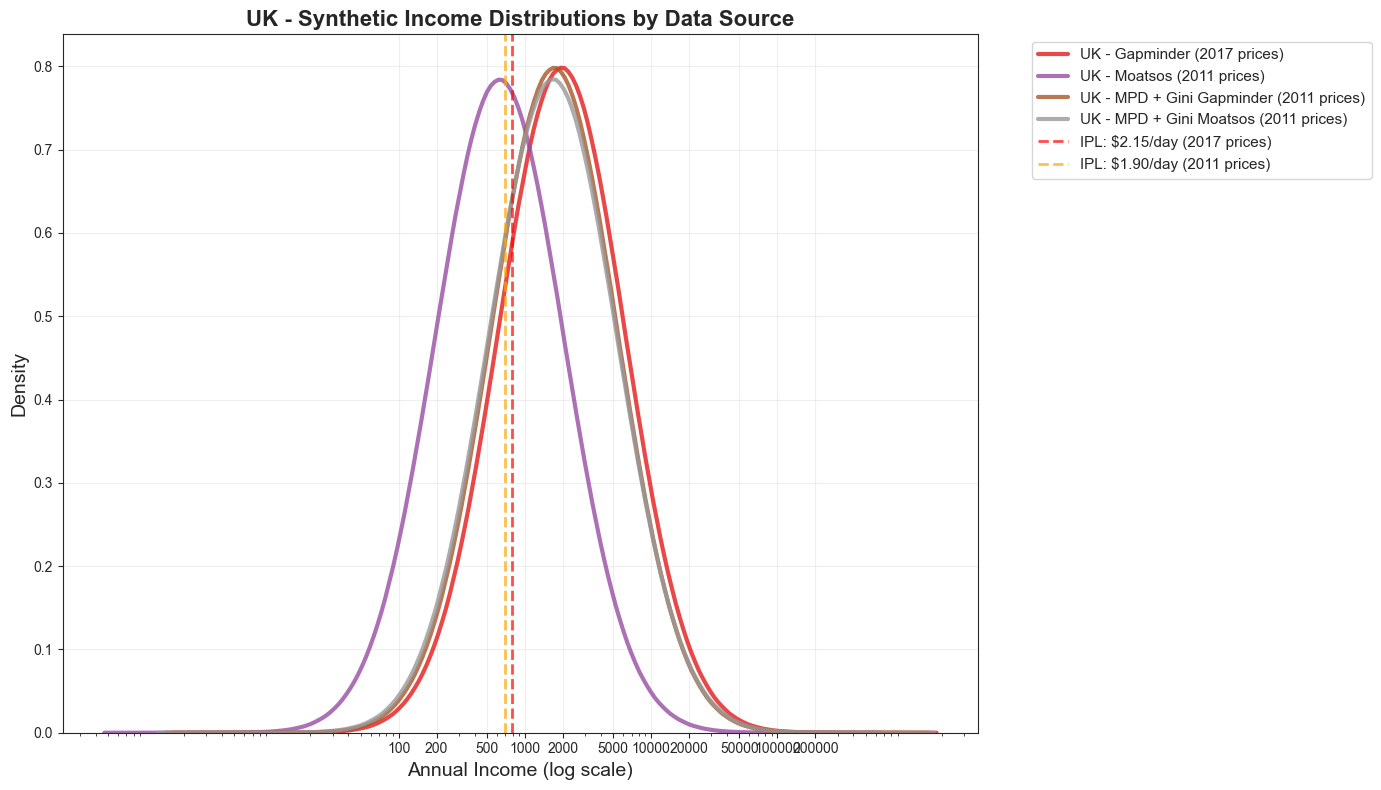

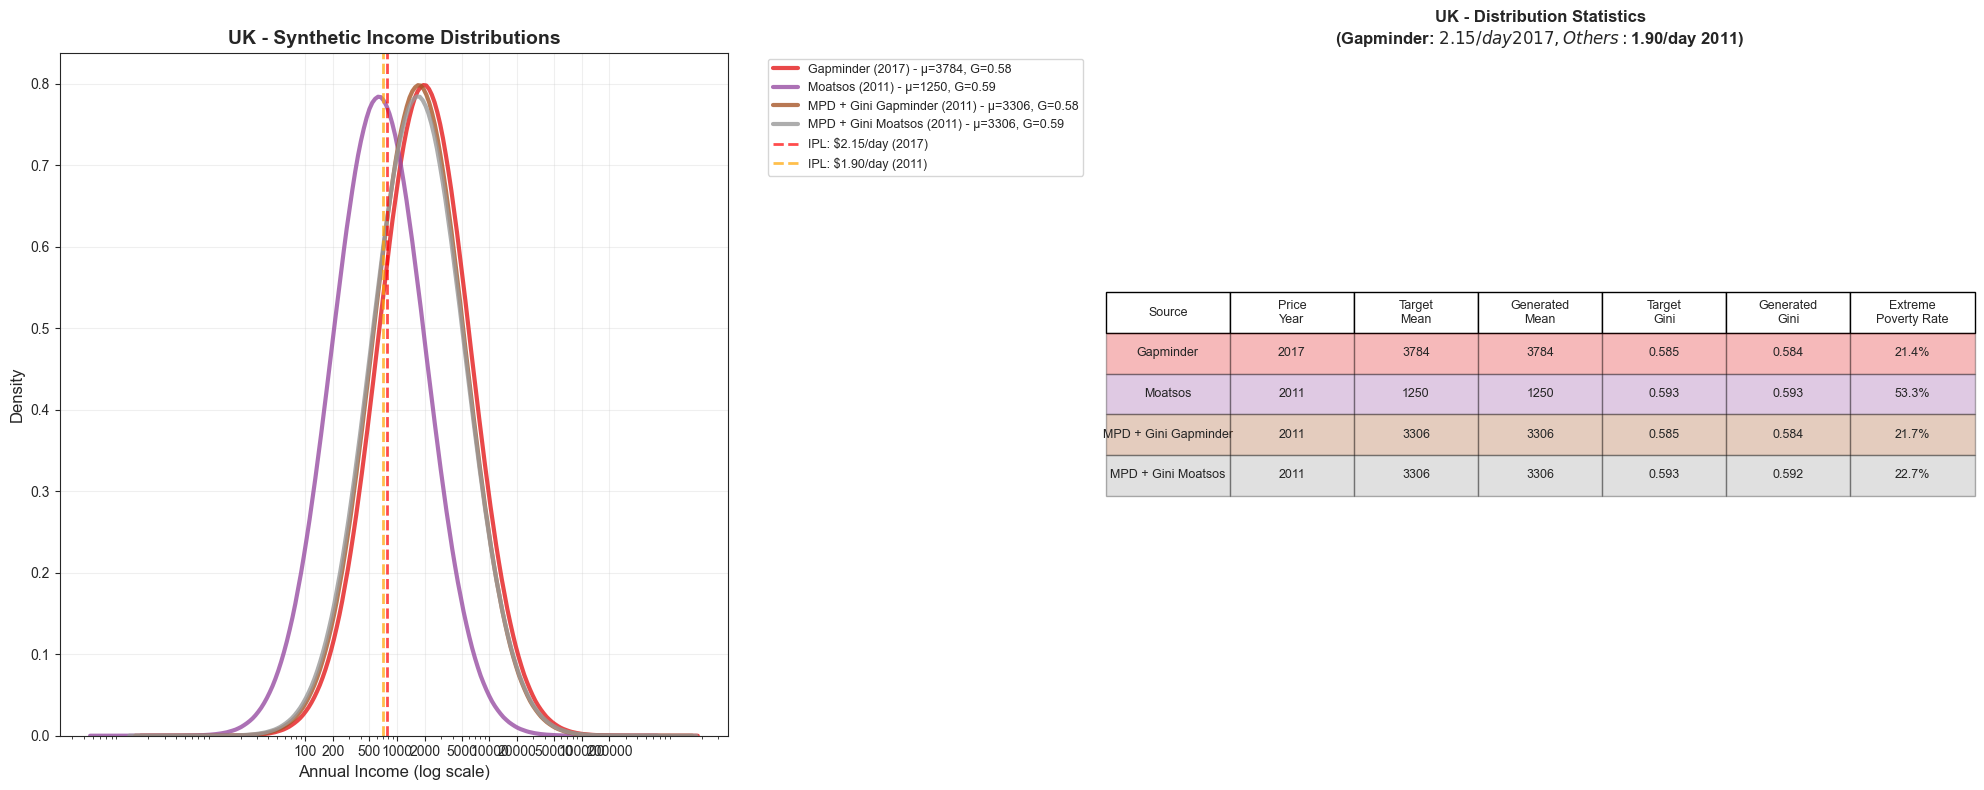


Sweden Distribution Analysis:


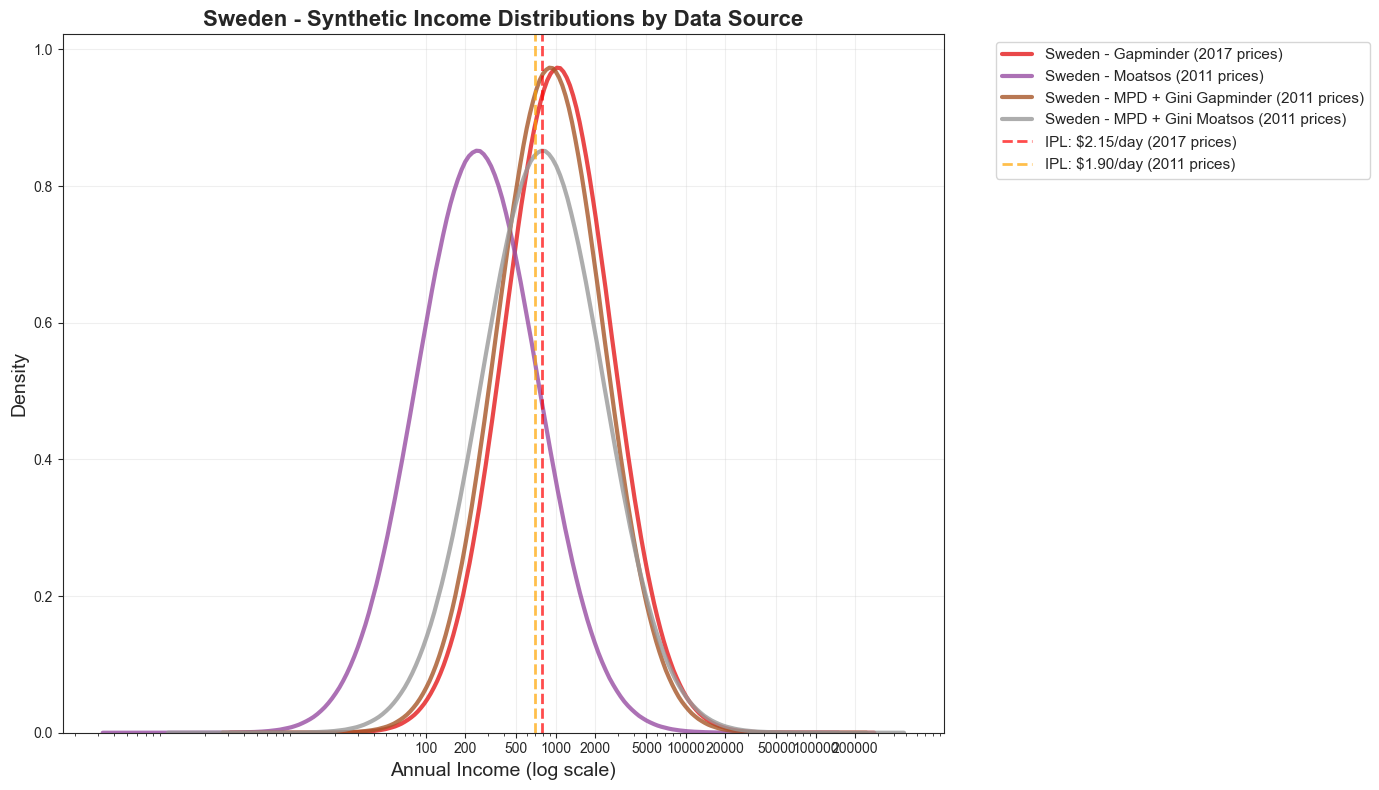

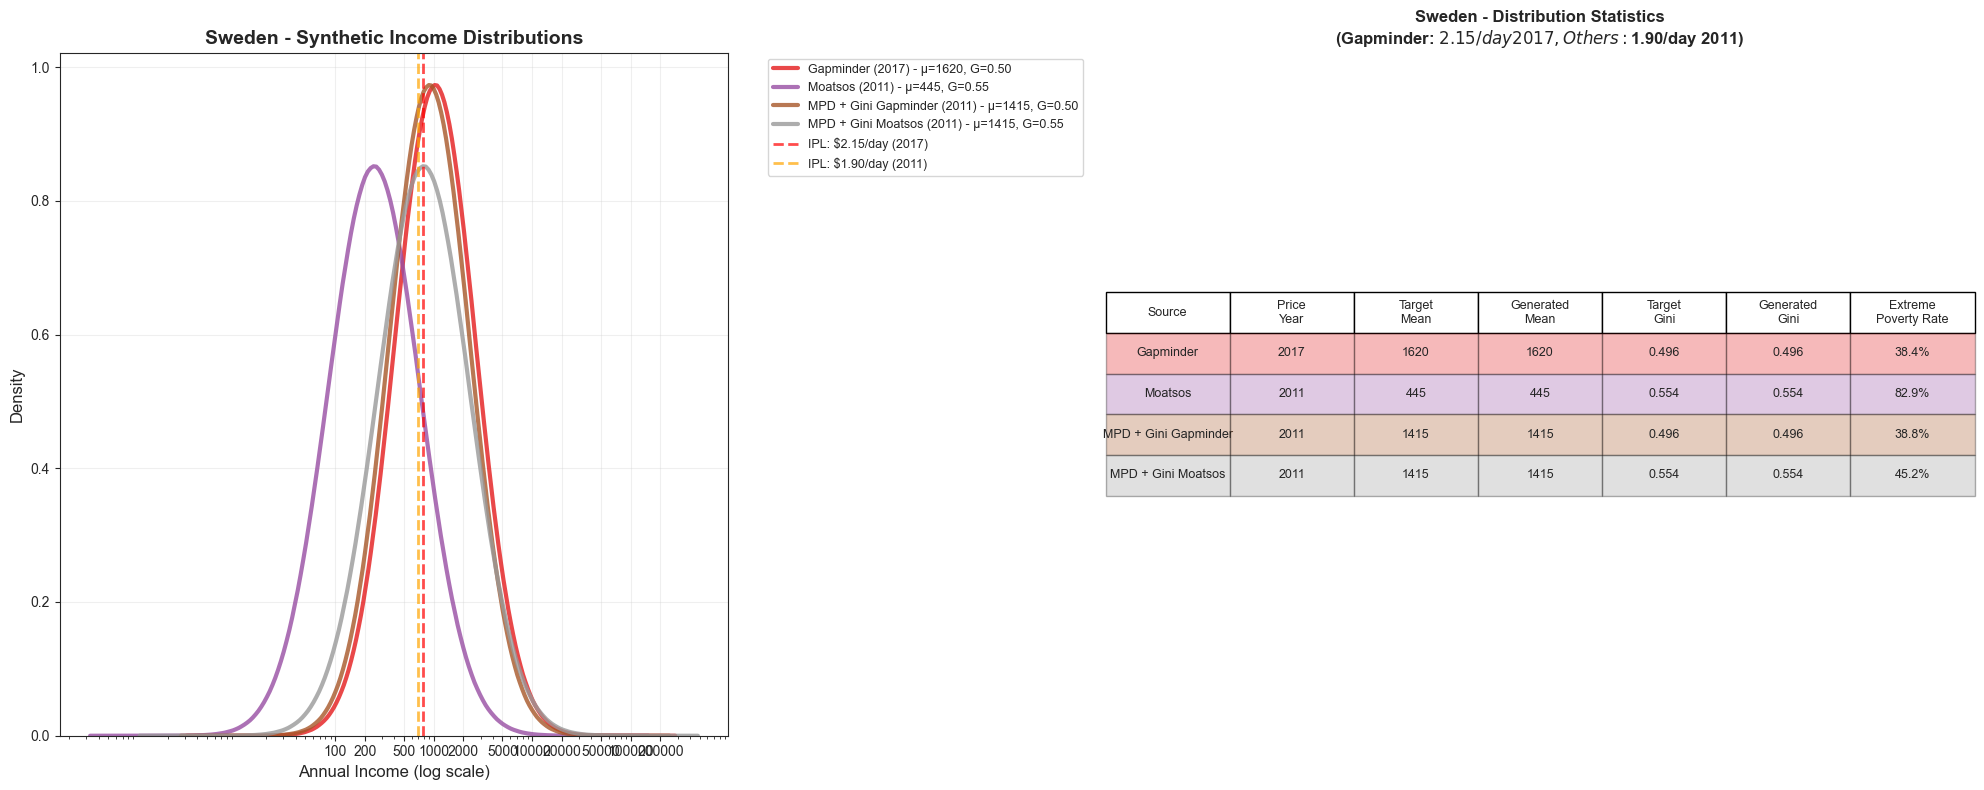

'\nplot_synthetic_data(\n    data=synthetic_data_uk_gapminder,\n    mean=generated_mean_uk_gapminder,\n    gini=generated_gini_uk_gapminder,\n    original_mean=target_mean_uk_gapminder,\n    original_gini=target_gini_uk_gapminder,\n    country="UK",\n    source="Gapminder",\n    ipl=2.15,\n)\nplot_synthetic_data(\n    data=synthetic_data_uk_moatsos,\n    mean=generated_mean_uk_moatsos,\n    gini=generated_gini_uk_moatsos,\n    original_mean=target_mean_uk_moatsos,\n    original_gini=target_gini_uk_moatsos,\n    country="UK",\n    source="Moatsos",\n    ipl=1.90,\n)\nplot_synthetic_data(\n    data=synthetic_data_uk_mpd_gapminder,\n    mean=generated_mean_uk_mpd_gapminder,\n    gini=generated_gini_uk_mpd_gapminder,\n    original_mean=target_mean_uk_mpd_gapminder,\n    original_gini=target_gini_uk_mpd_gapminder,\n    country="UK",\n    source="MPD + Gini Gapminder",\n    ipl=1.90,\n)\nplot_synthetic_data(\n    data=synthetic_data_uk_mpd_moatsos,\n    mean=generated_mean_uk_mpd_moatsos,\n 

In [8]:
# Set seaborn style and color palette
sns.set_style("ticks")
sns.set_palette("deep")

# Plot UK distributions separately
print("UK Distribution Analysis:")
print("=" * 50)
plot_country_distributions("UK")
plot_country_distributions_with_stats("UK")

print("\n" + "=" * 50)
print("Sweden Distribution Analysis:")
print("=" * 50)
plot_country_distributions("Sweden")
plot_country_distributions_with_stats("Sweden")

print("\n" + "=" * 50)

# Optional: Still show individual plots if needed (commented out)
"""
plot_synthetic_data(
    data=synthetic_data_uk_gapminder,
    mean=generated_mean_uk_gapminder,
    gini=generated_gini_uk_gapminder,
    original_mean=target_mean_uk_gapminder,
    original_gini=target_gini_uk_gapminder,
    country="UK",
    source="Gapminder",
    ipl=2.15,
)
plot_synthetic_data(
    data=synthetic_data_uk_moatsos,
    mean=generated_mean_uk_moatsos,
    gini=generated_gini_uk_moatsos,
    original_mean=target_mean_uk_moatsos,
    original_gini=target_gini_uk_moatsos,
    country="UK",
    source="Moatsos",
    ipl=1.90,
)
plot_synthetic_data(
    data=synthetic_data_uk_mpd_gapminder,
    mean=generated_mean_uk_mpd_gapminder,
    gini=generated_gini_uk_mpd_gapminder,
    original_mean=target_mean_uk_mpd_gapminder,
    original_gini=target_gini_uk_mpd_gapminder,
    country="UK",
    source="MPD + Gini Gapminder",
    ipl=1.90,
)
plot_synthetic_data(
    data=synthetic_data_uk_mpd_moatsos,
    mean=generated_mean_uk_mpd_moatsos,
    gini=generated_gini_uk_mpd_moatsos,
    original_mean=target_mean_uk_mpd_moatsos,
    original_gini=target_gini_uk_mpd_moatsos,
    country="UK",
    source="MPD + Gini Moatsos",
    ipl=1.90,
)
plot_synthetic_data(
    data=synthetic_data_sweden_gapminder,
    mean=generated_mean_sweden_gapminder,
    gini=generated_gini_sweden_gapminder,
    original_mean=target_mean_sweden_gapminder,
    original_gini=target_gini_sweden_gapminder,
    country="Sweden",
    source="Gapminder",
    ipl=2.15,
)
plot_synthetic_data(
    data=synthetic_data_sweden_moatsos,
    mean=generated_mean_sweden_moatsos,
    gini=generated_gini_sweden_moatsos,
    original_mean=target_mean_sweden_moatsos,
    original_gini=target_gini_sweden_moatsos,
    country="Sweden",
    source="Moatsos",
    ipl=1.90,
)
plot_synthetic_data(
    data=synthetic_data_sweden_mpd_gapminder,
    mean=generated_mean_sweden_mpd_gapminder,
    gini=generated_gini_sweden_mpd_gapminder,
    original_mean=target_mean_sweden_mpd_gapminder,
    original_gini=target_gini_sweden_mpd_gapminder,
    country="Sweden",
    source="MPD + Gini Gapminder",
    ipl=1.90,
)
plot_synthetic_data(
    data=synthetic_data_sweden_mpd_moatsos,
    mean=generated_mean_sweden_mpd_moatsos,
    gini=generated_gini_sweden_mpd_moatsos,
    original_mean=target_mean_sweden_mpd_moatsos,
    original_gini=target_gini_sweden_mpd_moatsos,
    country="Sweden",
    source="MPD + Gini Moatsos",
    ipl=1.90,
)
"""